## Merging affinity scores and expression data for downstream torchdms modeling

In this notebook, I process Tyler's RBD DMS data for future torchdms modeling.
Data files involved are:

* `binding_Kds.csv`, which estimates mutational effects on binding affinity for the ACE2 receptor
* `expression_mean.csv`, which measures expression of each variant (I beleive through yeast cell-surface expression

The output of this notebook is a single dataframe containing the library, barcode and amino acid substitutions for each variant, mean affinity score / variance, and mean expression score / variance.

In [1]:
import pandas as pd
import numpy as np

import dms_variants.binarymap
import dms_variants.globalepistasis

#### Import and format affinity score data
Note: Changign `delta_log10Ka` to `affinity_score`

In [6]:
df = pd.read_csv('results/binding_Kds/binding_Kds.csv')
df.rename(columns={'delta_log10Ka':'affinity_score'},inplace=True)
df['affinity_score_var'] = df['log10SE']**2
affinity_scores = df[pd.notnull(df['affinity_score'])].copy()
affinity_scores.fillna('',inplace=True)
affinity_scores.head()

,library,target,barcode,variant_call_support,avgcount,log10Ka,affinity_score,log10SE,response,baseline,nMSR,variant_class,aa_substitutions,n_aa_substitutions,affinity_score_var
2,lib1,SARS-CoV-2,AAAAAAAAACTTCAAT,5,74.50,8.72,-2.05,0.12,1.64,1.13,0.01,>1 nonsynonymous,A22C R127G E141D L188V,4,0.0144
3,lib1,SARS-CoV-2,AAAAAAAACAAGCAGA,6,146.32,10.35,-0.42,0.05,2.87,1.01,0.00,1 nonsynonymous,N13F,1,0.0025
5,lib1,SARS-CoV-2,AAAAAAAACAGGTTGC,4,47.48,6.00,-4.76,2.00,1.50,1.15,0.01,>1 nonsynonymous,V71K P149L N157T,3,4.0000
6,lib1,SARS-CoV-2,AAAAAAAACATTAAAT,6,47.44,10.15,-0.61,0.09,2.64,1.09,0.00,>1 nonsynonymous,A18V T148S H189Y,3,0.0081
8,lib1,SARS-CoV-2,AAAAAAAACCTTACAA,2,18.78,9.61,-1.15,0.19,2.00,1.11,0.01,>1 nonsynonymous,T63D A89N,2,0.0361


#### Import and format expression score data
The column `ML_meanF` reflects a maximum likelihood estimate of mean log fluorescence of each barcoded variant, and is renamed `expr_score` here

In [10]:
df = pd.read_csv('results/expression_meanFs/expression_meanFs.csv')
df.head()
df.rename(columns={'ML_meanF':'expr_score', 'var_ML_meanF':'expr_score_var'},inplace=True)
expr_scores = df[pd.notnull(df['expr_score'])].copy()
expr_scores.fillna('',inplace=True)
expr_scores.head()

,library,target,barcode,variant_call_support,total_count,expr_score,delta_ML_meanF,expr_score_var,variant_class,aa_substitutions,n_aa_substitutions
1,lib1,SARS-CoV-2,AAAAAAAAACTTAAAT,2,64.71,7.45,-3.01,0.04,>1 nonsynonymous,N13S L60P K94N S147T C150Y,5
2,lib1,SARS-CoV-2,AAAAAAAAACTTCAAT,5,117.96,7.92,-2.54,0.03,>1 nonsynonymous,A22C R127G E141D L188V,4
3,lib1,SARS-CoV-2,AAAAAAAACAAGCAGA,6,244.34,8.93,-1.53,0.01,1 nonsynonymous,N13F,1
4,lib1,SARS-CoV-2,AAAAAAAACAATATAA,1,95.35,6.21,-4.25,0.03,>1 nonsynonymous,C6K T15W K94Y V103W,4
5,lib1,SARS-CoV-2,AAAAAAAACAGGTTGC,4,212.43,7.73,-2.73,0.02,>1 nonsynonymous,V71K P149L N157T,3


#### Merge into one DF
Keep only the columns that will be relevant for `torchdms` analysis. Note that variants for which only one type of data is available will have NaN for other data.

In [11]:
dms_full = pd.merge(affinity_scores[['library','barcode','aa_substitutions',
                                     'n_aa_substitutions','affinity_score','affinity_score_var']],
                          expr_scores[['library','barcode','aa_substitutions',
                                       'n_aa_substitutions','expr_score','expr_score_var']],
                          how='outer',
                          on=['library','barcode','aa_substitutions','n_aa_substitutions'] 
                          )
dms_full

,library,barcode,aa_substitutions,n_aa_substitutions,affinity_score,affinity_score_var,expr_score,expr_score_var
0,lib1,AAAAAAAAACTTCAAT,A22C R127G E141D L188V,4,-2.05,0.0144,7.92,0.03
1,lib1,AAAAAAAACAAGCAGA,N13F,1,-0.42,0.0025,8.93,0.01
2,lib1,AAAAAAAACAGGTTGC,V71K P149L N157T,3,-4.76,4.0000,7.73,0.02
3,lib1,AAAAAAAACATTAAAT,A18V T148S H189Y,3,-0.61,0.0081,8.82,0.03
4,lib1,AAAAAAAACCTTACAA,T63D A89N,2,-1.15,0.0361,8.39,0.03
...,...,...,...,...,...,...,...,...
184688,lib2,TTTTTGCCTAGGAGAC,V103Y C150S C158D,3,NaN,NaN,7.55,0.04
184689,lib2,TTTTTTAATGAAGGTC,S41V T63I G86* W106V,4,NaN,NaN,5.77,0.01
184690,lib2,TTTTTTAGAAATATAT,N4V A18D Q176L,3,NaN,NaN,7.59,0.04
184691,lib2,TTTTTTCACGAGAAGC,T15R N40D T100S L162C,4,NaN,NaN,7.52,0.03


#### Check distrubution of `n_aa_substitutions`

array([[<AxesSubplot:title={'center':'n_aa_substitutions'}>]],
      dtype=object)

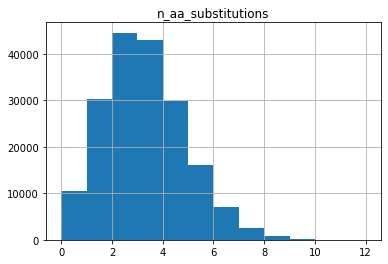

In [14]:
dms_full.hist(column='n_aa_substitutions', bins=dms_full.n_aa_substitutions.max())

In [20]:
dms_full.loc[dms_full['n_aa_substitutions'] == 0 ]

,library,barcode,aa_substitutions,n_aa_substitutions,affinity_score,affinity_score_var,expr_score,expr_score_var
8,lib1,AAAAAAAAGGACGGAA,,0,-0.04,0.0025,10.37,0.01
42,lib1,AAAAAAATAATATACC,,0,-0.01,0.0025,10.56,0.02
57,lib1,AAAAAACAACAATATC,,0,0.07,0.0049,10.52,0.04
64,lib1,AAAAAACATCTGCATG,,0,0.02,0.0036,10.52,0.01
75,lib1,AAAAAACGGTTGCATA,,0,0.16,0.0529,10.56,0.06
...,...,...,...,...,...,...,...,...
183071,lib2,TGCTAAATAGACTAAA,,0,NaN,NaN,5.91,0.02
183252,lib2,TGGGTATAAGGGAGAT,,0,NaN,NaN,5.82,0.01
183432,lib2,TGTTAGATCAAGGTCG,,0,NaN,NaN,10.25,0.08
183778,lib2,TTAGCGTCTTAATAAG,,0,NaN,NaN,5.74,0.02


#### Define wt-seq
Define wildtype sequence -- I got this string from [here](https://www.ncbi.nlm.nih.gov/nuccore/MT318827).
Double check string length should be 201 (from Tyler's paper), and that no position is referenced above this value in `aa_substitutions`

In [22]:
wtseq = "NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST"
len(wtseq)

201

In [26]:
# Confirm that no position above len(wtseq) is referenced in 'aa_substitutions'
l = dms_full['aa_substitutions'].str.contains(r"2[0-9][2-9]|[3-9][0-9][0-9]")
assert [i for i, x in enumerate(l) if x] == []

#### Write to pickle file
Pickle dataframe with wtseq  and export to `results/merged_torchdms`

In [29]:
import pickle
with open("results/merged_torchdms/SARS-CoV-2-RBD_dms_merged.pkl", "wb") as f:
    pickle.dump([dms_full, wtseq], f)